# HR Analytics

<img src = 'https://datahack-prod.s3.ap-south-1.amazonaws.com/__sized__/contest_cover/hr_1920x480_s5WuoZs-thumbnail-1200x1200-90.jpg'>

Practice Problem: https://datahack.analyticsvidhya.com/contest/wns-analytics-hackathon-2018-1/

## HR Analytics

HR analytics is revolutionising the way human resources departments operate, leading to higher efficiency and better results overall. Human resources has been using analytics for years. However, the collection, processing and analysis of data has been largely manual, and given the nature of human resources dynamics and HR KPIs, the approach has been constraining HR. Therefore, it is surprising that HR departments woke up to the utility of machine learning so late in the game. Here is an opportunity to try predictive analytics in identifying the employees most likely to get promoted.

## Problem Statement

Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion *(only for manager position and below)* and prepare them in time. Currently the process, they are following is:

* They first identify a set of employees based on recommendations/ past performance
* Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
* At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion

For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle. 

<img src = 'https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/09/wns_hack_im_1.jpg'>

They have provided multiple attributes around Employee's past and current performance along with demographics. Now, The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process.

## Métrica de evaluación

La métrica de evaluación en el conjunto de test será el área bajo la curva ROC (`auc_score`)

## Paquetes

In [1]:
# pip install xgboost

In [220]:
import numpy as np # tratamiento de arreglos
import pandas as pd # tratamiento y carga de dataframes
import warnings # para ignorar las advertencias innecesarias de pandas

import matplotlib
import matplotlib.pyplot as plt # Graficos y matriz de graficos
import seaborn as sns # Graficar las distribuciones

import missingno as msno # analissi de missing

import sklearn
from sklearn.model_selection import train_test_split # paraticion de la data
from sklearn.impute import SimpleImputer # imputacion numericas y categoricas
from sklearn.preprocessing import MinMaxScaler # Estandarizacion

import imblearn
from imblearn.under_sampling import RandomUnderSampler # submuestreo
from imblearn.over_sampling import RandomOverSampler # sobremuestreo

# Modelos
from sklearn.model_selection import GridSearchCV # Tuning de parametros

from sklearn.ensemble import RandomForestClassifier # Random Forest
import xgboost as xgb # xgboost
from xgboost import XGBClassifier as xgbc # clasificador

# Metricas
from sklearn.metrics import roc_auc_score, roc_curve # AUC


In [3]:
warnings.filterwarnings('ignore')
# graficos en el notebook
%matplotlib inline
# ajuste de la imagen a 144 píxeles por pulgada en lugar de los 72 por defecto.
%config InlineBackend.figure_format = 'retina'
# aumentamos el nro de columnas que muestra pandas
pd.set_option('display.max_columns', 100)
# Establece parametros en los graficos de la libreria. En este caso es restablecerlo al por defecto
sns.set()

In [4]:
v_pd = pd.__version__
v_np = np.__version__
v_plt = matplotlib.__version__
v_skl = sklearn.__version__
v_sns = sns.__version__
v_mso = msno.__version__
v_imb = imblearn.__version__

In [5]:
libraries = ['pandas', 'seaborn', 'matplotlib', 'sklearn', 'seaborn', 'missingno', 'imblearn']
versions = [v_pd, v_np, v_plt, v_skl, v_sns, v_mso, v_imb]

for i, j in zip(libraries, versions):
    print(f"{i} con version {j}")

pandas con version 1.1.5
seaborn con version 1.19.5
matplotlib con version 3.3.4
sklearn con version 0.24.2
seaborn con version 0.11.1
missingno con version 0.5.0
imblearn con version 0.8.0


In [6]:
# Dibuja la curva ROC
def plot_roc_curve(y, y_proba, label = ''):
    '''
    dibujar la curva roc para las probabilidades y target entregados
    
    params:
    y: etiquetas originales
    y_proba: probabilidades resultado del modelo
    '''
    
    auc_roc = roc_auc_score(y, y_proba)
    fpr, tpr, thresholds = roc_curve(y, y_proba)
    
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 12})
    plt.plot(fpr, fpr, c = 'red')
    plt.plot(fpr, tpr, label= (f"Curva ROC {label} (AUC = {auc_roc:.4f})"))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"Curva ROC {label}")
    plt.legend(loc=4, numpoints=1)

In [7]:
seed = 314159

In [8]:
data = pd.read_csv('train_LZdllcl.csv', sep=',')

In [9]:
data.head(2)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0


In [10]:
data.shape

(54808, 14)

In [11]:
data.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [12]:
data.head(2)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0


In [13]:
data.describe(
    # include = 'number', # by default
    percentiles = [.01, .025, .05, .075, .1, .9, .925, .95, .975, .99]
)

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
1%,795.070000,1.000000,23.000000,1.000000,1.000000,0.000000,0.000000,44.000000,0.000000
2.5%,1956.175000,1.000000,24.000000,1.000000,1.000000,0.000000,0.000000,46.000000,0.000000
5%,3916.350000,1.000000,25.000000,1.000000,1.000000,0.000000,0.000000,47.000000,0.000000
7.5%,5875.100000,1.000000,26.000000,1.000000,1.000000,0.000000,0.000000,47.000000,0.000000
10%,7849.700000,1.000000,27.000000,1.000000,2.000000,0.000000,0.000000,48.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000


In [14]:
data.describe(
    include = 'object'
)

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


In [15]:
data.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [16]:
id_columns = 'employee_id'
target = 'is_promoted'

is_promoted                0          1
department                             
Legal              94.898941   5.101059
HR                 94.375517   5.624483
R&D                93.093093   6.906907
Sales & Marketing  92.796912   7.203088
Finance            91.876972   8.123028
Operations         90.985196   9.014804
Analytics          90.433483   9.566517
Procurement        90.361446   9.638554
Technology         89.240684  10.759316


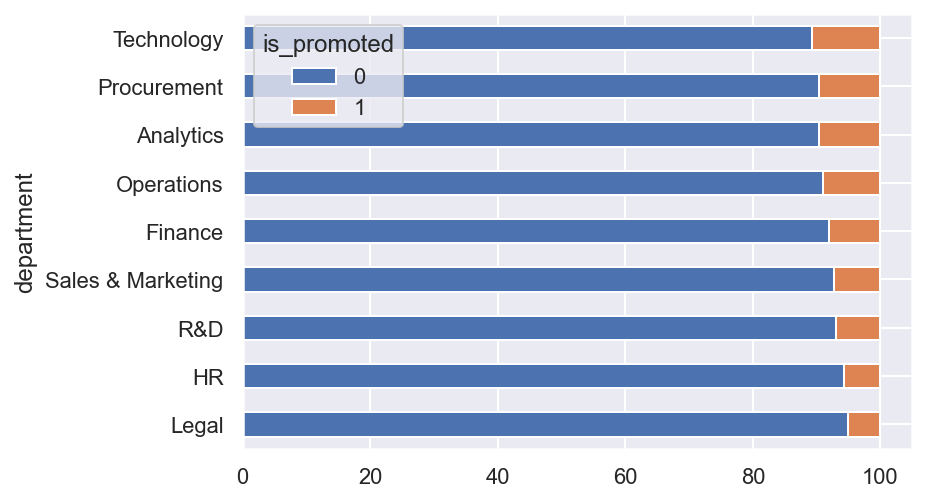

In [17]:
# departamento
tb_department = pd.crosstab(index=data['department'], columns=data['is_promoted'], margins=False).apply(lambda r: r/r.sum() *100, axis=1).sort_values(by=1)
print(tb_department); tb_department.plot(kind='barh', stacked=True); pass

is_promoted               0         1
education                            
Bachelor's        91.796886  8.203114
Below Secondary   91.677019  8.322981
Master's & above  90.144054  9.855946


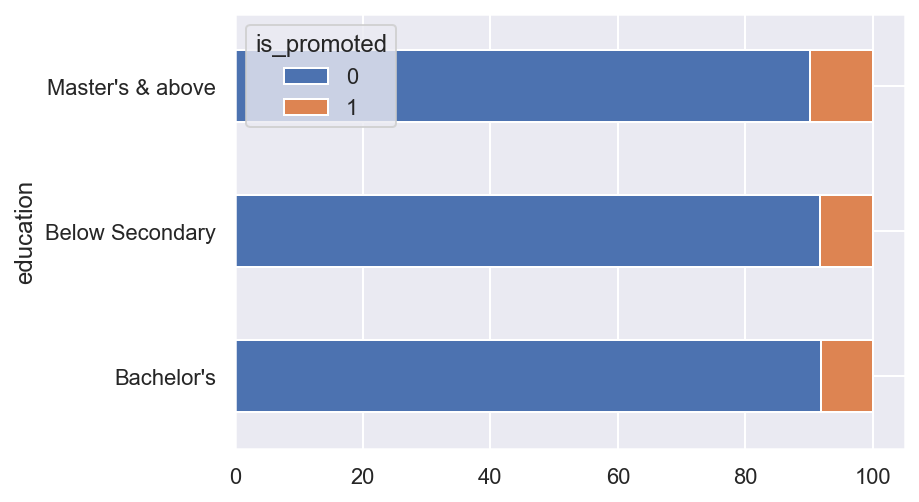

In [18]:
# education
tb_education = pd.crosstab(index=data['education'], columns=data['is_promoted'], margins=False).apply(lambda r: r/r.sum() *100, axis=1).sort_values(by=1)
print(tb_education); tb_education.plot(kind='barh', stacked=True); pass

is_promoted          0         1
gender                          
m            91.684850  8.315150
f            91.006621  8.993379


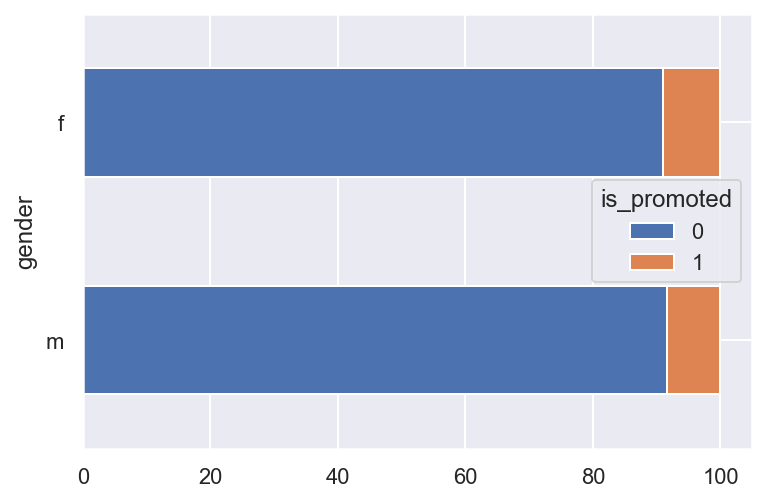

In [19]:
# gender
tb_gender = pd.crosstab(index=data['gender'], columns=data['is_promoted'], margins=False).apply(lambda r: r/r.sum() *100, axis=1).sort_values(by=1)
print(tb_gender); tb_gender.plot(kind='barh', stacked=True); pass

is_promoted                  0          1
recruitment_channel                      
other                91.604809   8.395191
sourcing             91.498708   8.501292
referred             87.915937  12.084063


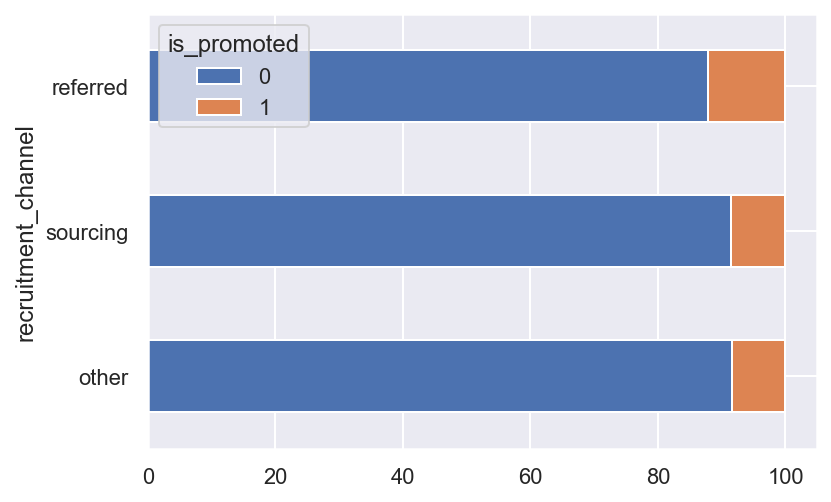

In [20]:
# recruitment_channel
tb_recruitment_channel = pd.crosstab(index=data['recruitment_channel'], columns=data['is_promoted'], margins=False).apply(lambda r: r/r.sum() *100, axis=1).sort_values(by=1)
print(tb_recruitment_channel); tb_recruitment_channel.plot(kind='barh', stacked=True); pass

is_promoted          0          1
awards_won?                      
0            92.325078   7.674922
1            55.984252  44.015748


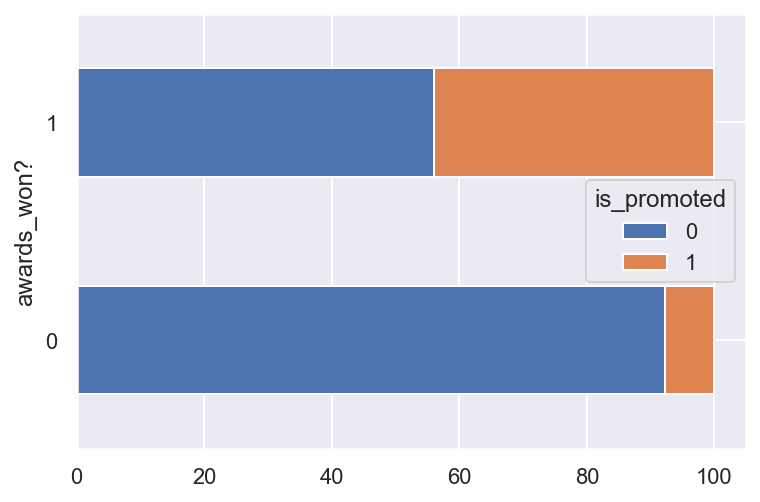

In [21]:
# tb_awards_won
tb_awards_won = pd.crosstab(index=data['awards_won?'], columns=data['is_promoted'], margins=False).apply(lambda r: r/r.sum() *100, axis=1).sort_values(by=1)
print(tb_awards_won); tb_awards_won.plot(kind='barh', stacked=True); pass

## División en conjuntos de entrenamiento y validación

### división en features y target

In [22]:
X = data.drop([target, id_columns], axis = 1)
y = data[target]

In [23]:
X.head(2)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60


In [24]:
y.head(2)

0    0
1    0
Name: is_promoted, dtype: int64

In [25]:
X.shape

(54808, 12)

In [26]:
y.shape

(54808,)

In [27]:
y.mean()

0.08517004816815063

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed, stratify = y)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43846, 12), (10962, 12), (43846,), (10962,))

In [30]:
y_train.mean()

0.08516170232176254

In [31]:
y_test.mean()

0.08520343003101624

In [32]:
y_train.value_counts()

0    40112
1     3734
Name: is_promoted, dtype: int64

In [33]:
y_test.value_counts()

0    10028
1      934
Name: is_promoted, dtype: int64

### Se usaran modelos en los cuales `no es necesario el escalamiento`

## Analisis Exploratorio de Datos

In [34]:
X_train.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score'],
      dtype='object')

In [35]:
X_train.describe(
    # include = 'number', # by default
    percentiles = [.01, .025, .05, .075, .1, .9, .925, .95, .975, .99]
)

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,43846.000000,43846.000000,40527.000000,43846.000000,43846.000000,43846.000000,43846.000000
mean,1.251859,34.834147,3.328571,5.878666,0.353396,0.023263,63.352005
std,0.606720,7.684092,1.260799,4.283383,0.478030,0.150740,13.333038
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
1%,1.000000,23.000000,1.000000,1.000000,0.000000,0.000000,44.000000
2.5%,1.000000,24.000000,1.000000,1.000000,0.000000,0.000000,46.000000
5%,1.000000,25.000000,1.000000,1.000000,0.000000,0.000000,47.000000
7.5%,1.000000,26.000000,1.000000,1.000000,0.000000,0.000000,48.000000
10%,1.000000,27.000000,1.000000,2.000000,0.000000,0.000000,48.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000


<AxesSubplot:xlabel='no_of_trainings', ylabel='count'>

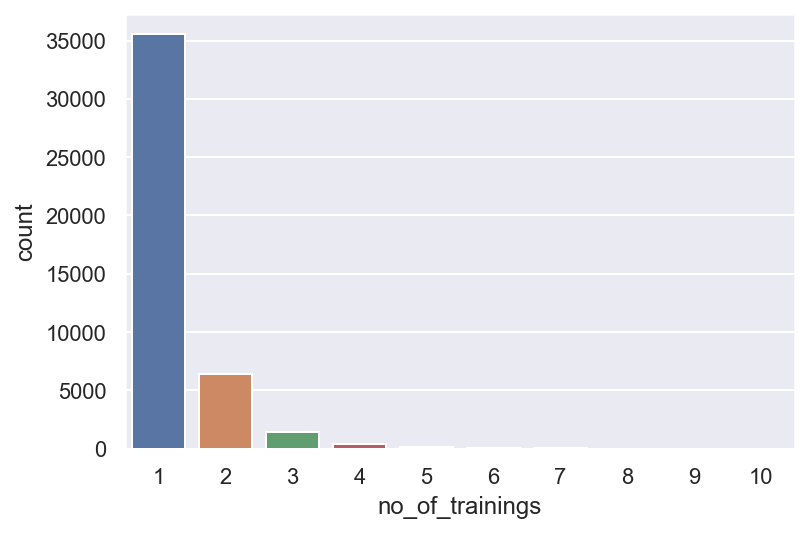

In [36]:
sns.countplot(data = X_train, x = 'no_of_trainings')

<AxesSubplot:xlabel='age', ylabel='Count'>

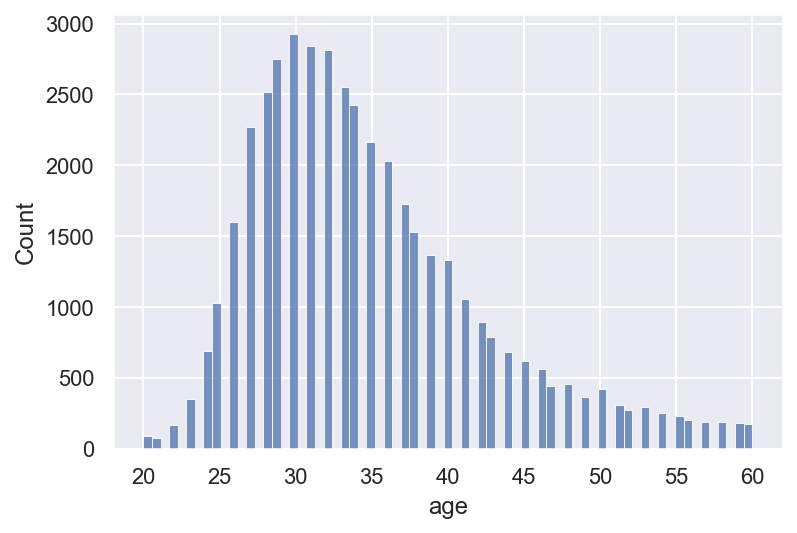

In [37]:
sns.histplot(data = X_train, x = 'age')

<AxesSubplot:xlabel='previous_year_rating', ylabel='count'>

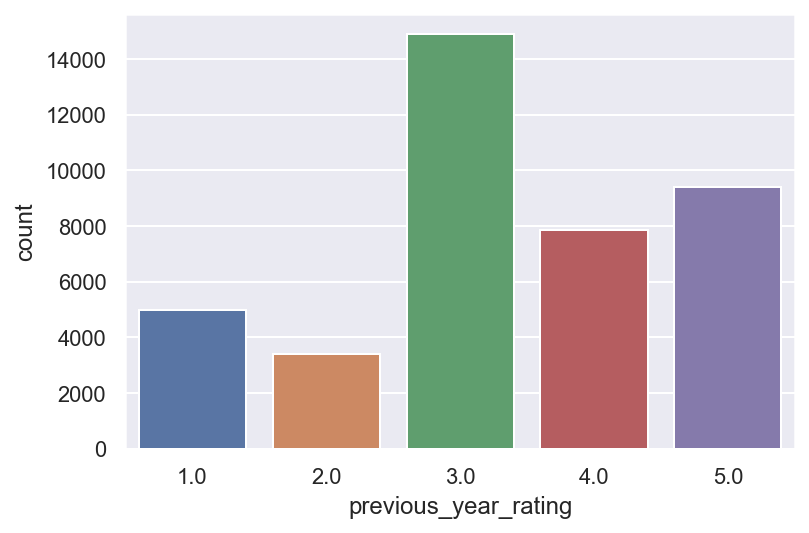

In [38]:
sns.countplot(data = X_train, x = 'previous_year_rating')

<AxesSubplot:xlabel='length_of_service', ylabel='Count'>

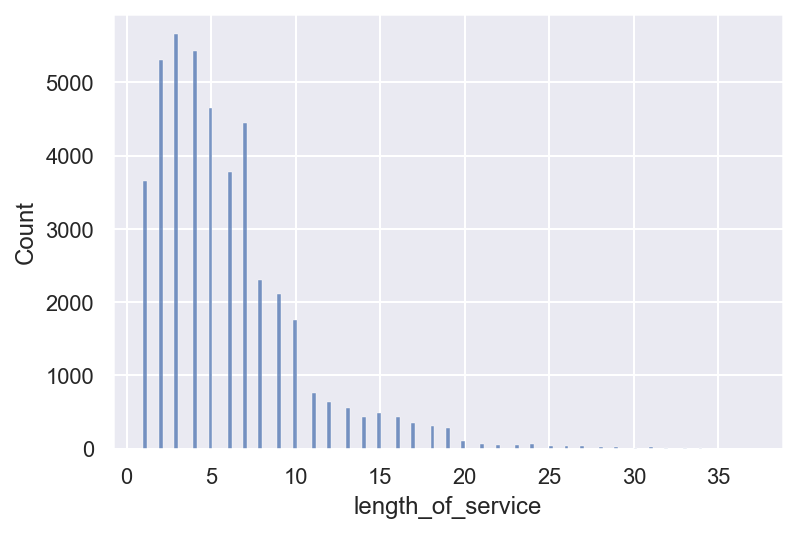

In [39]:
sns.histplot(data = X_train, x = 'length_of_service')

<AxesSubplot:xlabel='avg_training_score', ylabel='Count'>

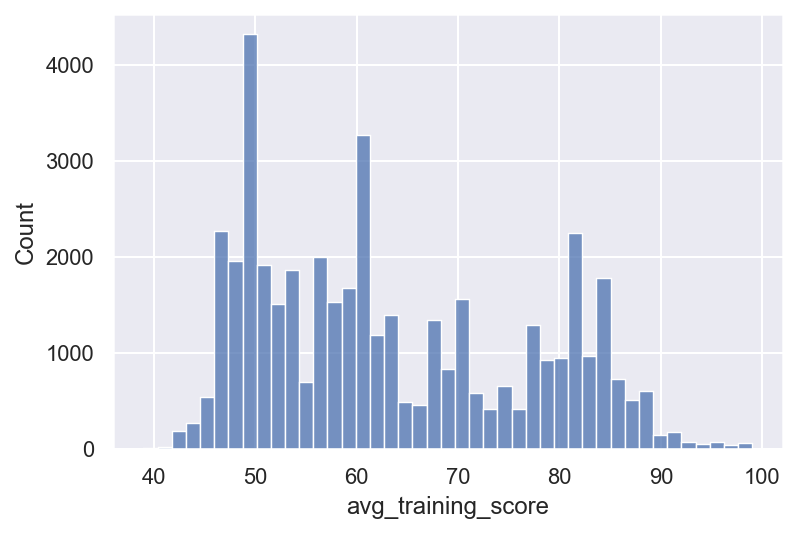

In [40]:
sns.histplot(data = X_train, x = 'avg_training_score')

In [41]:
X_train.describe(
    include = 'object'
)

,department,region,education,gender,recruitment_channel
count,43846,43846,41936,43846,43846
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,13453,9921,29356,30809,24344


<AxesSubplot:xlabel='count', ylabel='department'>

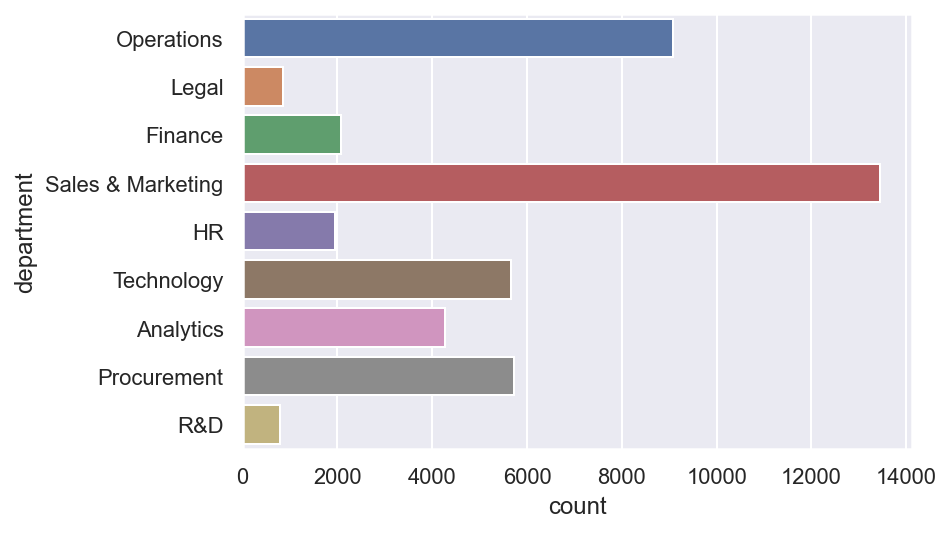

In [42]:
sns.countplot(data = X_train, y = 'department')

<AxesSubplot:xlabel='count', ylabel='education'>

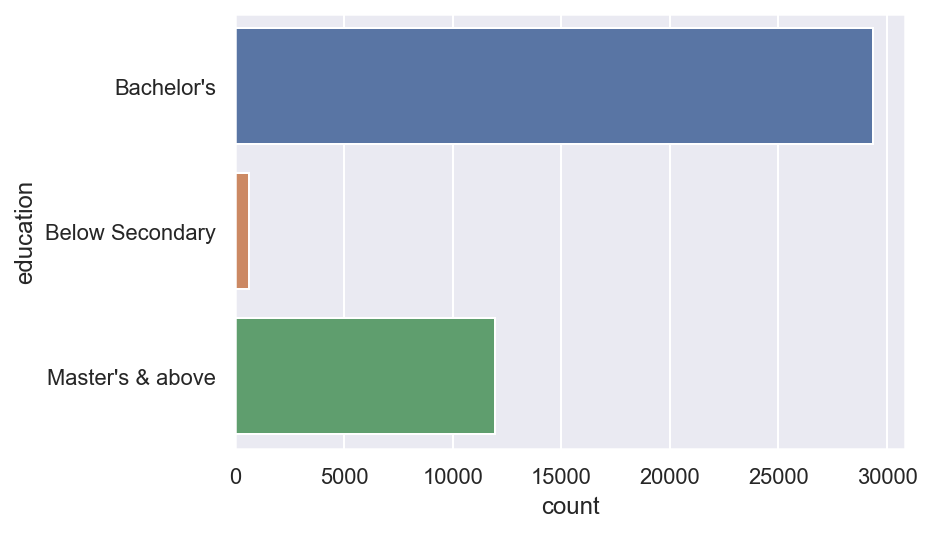

In [43]:
sns.countplot(data = X_train, y = 'education')

<AxesSubplot:xlabel='recruitment_channel', ylabel='count'>

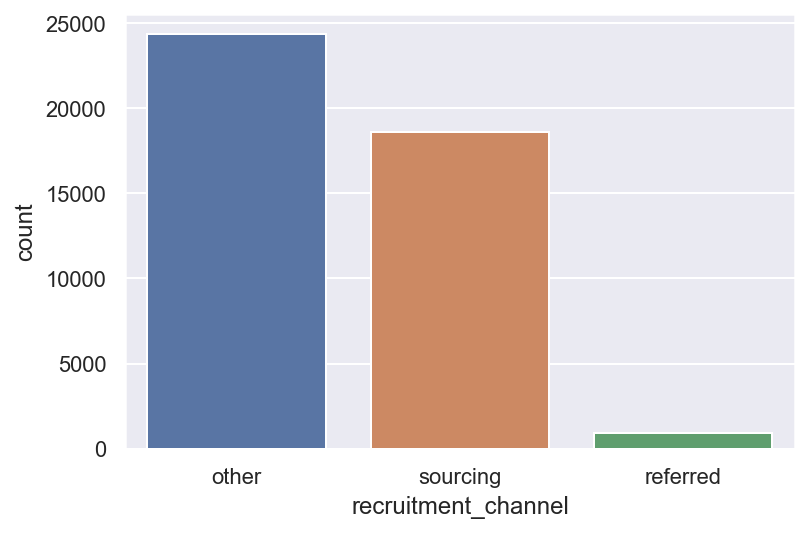

In [44]:
sns.countplot(data = X_train, x = 'recruitment_channel')

### Analizamos la correlacion

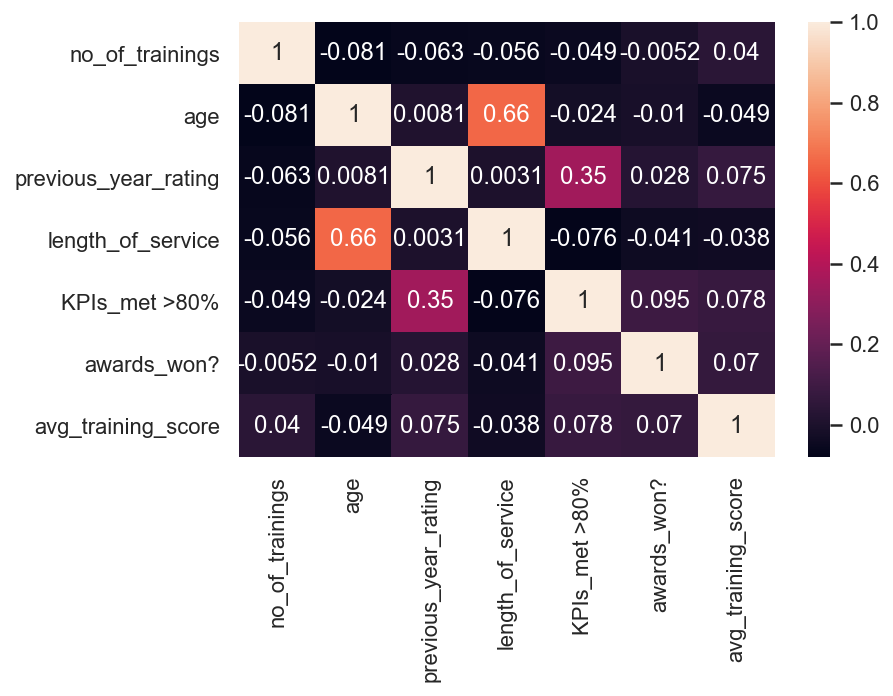

In [45]:
sns.heatmap(X_train.corr(), annot = True);

### `Existe correlacion entre el tiempo de servicio y los anios del trabajador.`
### `La correlacion entre si el KPI es mayor al 80% y el puntaje del trabajador en el anio anterior es mayor al de los demas, pero esta en los limites (60%, experiencia del experimentador)`

### Analizamos los nulos

In [46]:
X_train.isna().sum()

department                 0
region                     0
education               1910
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    3319
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [47]:
X_train[['education', 'previous_year_rating']].isna().mean()

education               0.043562
previous_year_rating    0.075697
dtype: float64

<AxesSubplot:>

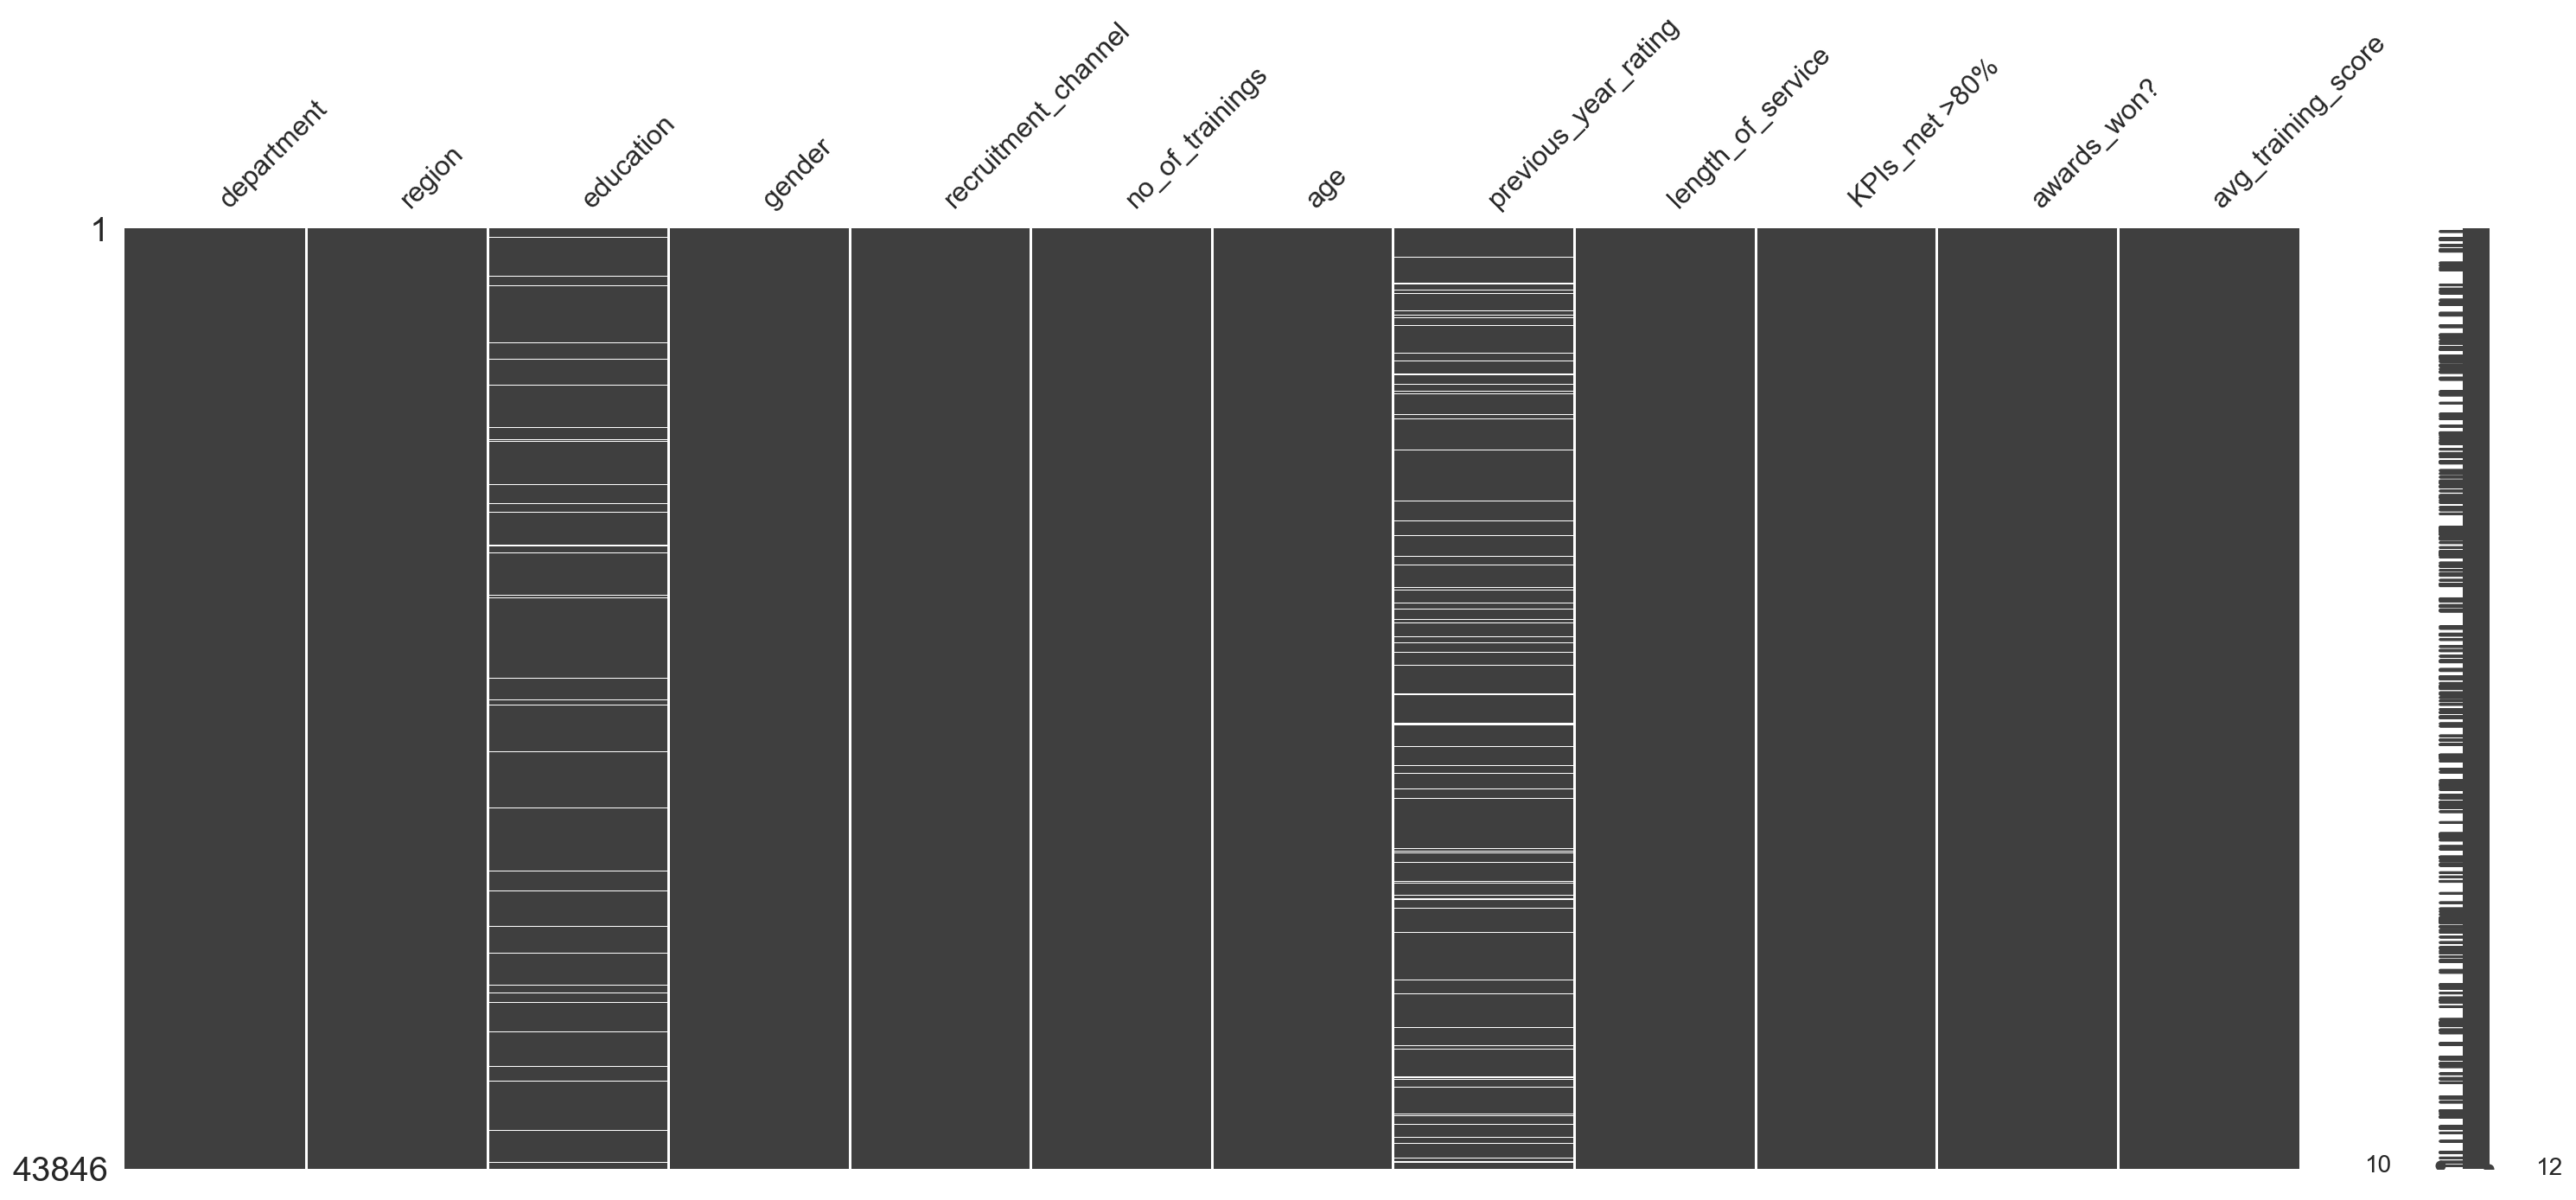

In [48]:
msno.matrix(X_train)

In [49]:
X_train_num = X_train.select_dtypes('number')
X_train_cat = X_train.select_dtypes('object')

In [50]:
X_train_num.head(2)

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
11129,1,38,3.0,5,0,0,57
4604,1,29,4.0,4,0,0,60


In [51]:
X_train_cat.head(2)

,department,region,education,gender,recruitment_channel
11129,Operations,region_22,Bachelor's,f,other
4604,Legal,region_22,Bachelor's,f,other


## Preprocesamiento

### imputación numéricas

In [52]:
X_train_num.isnull().sum()

no_of_trainings            0
age                        0
previous_year_rating    3319
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [53]:
X_train_num_imputed = X_train_num

### considerando un mayor rating como mejor calificado, imputamos a los no calificados con 0

In [54]:
X_train_num_imputed[ "previous_year_rating"] = X_train_num_imputed["previous_year_rating"].fillna(0)

### imputación categoricos

In [55]:
X_train_cat.isnull().sum()

department                0
region                    0
education              1910
gender                    0
recruitment_channel       0
dtype: int64

In [56]:
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_cat.fit(X_train_cat)
X_train_cat_imputed = pd.DataFrame(imputer_cat.transform(X_train_cat), columns = X_train_cat.columns)

X_train_cat_imputed.head(2)

,department,region,education,gender,recruitment_channel
0,Operations,region_22,Bachelor's,f,other
1,Legal,region_22,Bachelor's,f,other


### Tratamiento atipicos

In [57]:
p_01_not = np.percentile(X_train_num_imputed['no_of_trainings'], 1)
p_99_not = np.percentile(X_train_num_imputed['no_of_trainings'], 99)

In [58]:
p_01_not, p_99_not

(1.0, 4.0)

In [59]:
X_train_num_imputed['no_of_trainings'] = np.clip(X_train_num_imputed['no_of_trainings'], p_01_not, p_99_not)

### Encoding de variables categóricas

In [60]:
X_train_cat_dummies = pd.get_dummies(X_train_cat_imputed, drop_first= True)

### Recuperamos los indices antes de la consolidacion

In [61]:
X_train_cat_dummies.index = X_train_cat.index

In [62]:
X_train_cat_dummies.head(2)

,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
11129,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4604,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Consolidación

In [63]:
X_train_cat_dummies.head(2)

,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
11129,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4604,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
X_train_num_imputed.head(2)

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
11129,1,38,3.0,5,0,0,57
4604,1,29,4.0,4,0,0,60


In [65]:
X_train_cat_dummies.shape, X_train_num_imputed.shape

((43846, 46), (43846, 7))

In [66]:
X_train_total = pd.concat([X_train_num_imputed, X_train_cat_dummies], axis = 1)

In [67]:
X_train_total.head(2)

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
11129,1,38,3.0,5,0,0,57,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4604,1,29,4.0,4,0,0,60,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
X_train_total.isnull().sum()

no_of_trainings                 0
age                             0
previous_year_rating            0
length_of_service               0
KPIs_met >80%                   0
awards_won?                     0
avg_training_score              0
department_Finance              0
department_HR                   0
department_Legal                0
department_Operations           0
department_Procurement          0
department_R&D                  0
department_Sales & Marketing    0
department_Technology           0
region_region_10                0
region_region_11                0
region_region_12                0
region_region_13                0
region_region_14                0
region_region_15                0
region_region_16                0
region_region_17                0
region_region_18                0
region_region_19                0
region_region_2                 0
region_region_20                0
region_region_21                0
region_region_22                0
region_region_

## Estandarización

In [69]:
scaler = MinMaxScaler()

In [70]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_total), columns = X_train_total.columns)

In [71]:
X_train_total.head(2)

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
11129,1,38,3.0,5,0,0,57,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4604,1,29,4.0,4,0,0,60,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
X_train_scaled.head(2)

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
0,0.0,0.450,0.6,0.111111,0.0,0.0,0.30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.225,0.8,0.083333,0.0,0.0,0.35,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
X_train_scaled.describe(percentiles = [.01, .025, .05, .075, .1, .9, .925, .95, .975, .99])

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
count,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.00000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000
mean,0.081999,0.370854,0.615322,0.135519,0.353396,0.023263,0.405867,0.047507,0.044565,0.019181,0.20718,0.130434,0.018040,0.306824,0.129043,0.011997,0.023902,0.008918,0.048830,0.014756,0.051612,0.026183,0.014095,0.000547,0.016375,0.226269,0.015646,0.007549,0.117616,0.021097,0.009397,0.014688,0.041190,0.030630,0.023811,0.018383,0.006660,0.011700,0.034849,0.017242,0.004767,0.005542,0.031428,0.014254,0.012156,0.087397,0.011632,0.007686,0.014460,0.272454,0.702664,0.020435,0.424349
std,0.188993,0.192102,0.299632,0.118983,0.478030,0.150740,0.222217,0.212723,0.206349,0.137162,0.40529,0.336784,0.133099,0.461181,0.335251,0.108871,0.152745,0.094012,0.215515,0.120577,0.221246,0.159680,0.117883,0.023390,0.126916,0.418420,0.124102,0.086558,0.322157,0.143708,0.096480,0.120301,0.198731,0.172315,0.152460,0.134332,0.081336,0.107533,0.183400,0.130174,0.068877,0.074240,0.174474,0.118539,0.109584,0.282419,0.107222,0.087333,0.119377,0.445227,0.457091,0.141485,0.494249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.000000,0.075000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.5%,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.116667,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

## Repetir todo el preprocesamiento para el conjunto de test

In [74]:
X_test_num = X_test.select_dtypes('number')
X_test_cat = X_test.select_dtypes('object')

### Imputacion

In [75]:
X_test_num_imputed = X_test_num

In [76]:
X_test_num_imputed[ "previous_year_rating"] = X_test_num_imputed["previous_year_rating"].fillna(0)

In [77]:
X_test_cat_imputed = pd.DataFrame(imputer_cat.transform(X_test_cat), columns = X_test_cat.columns)

### Tratamiento atipicos

In [78]:
X_test_num_imputed['no_of_trainings'] = np.clip(X_test_num_imputed['no_of_trainings'], p_01_not, p_99_not)

### Encoding de variables categóricas

In [79]:
X_test_cat_dummies = pd.get_dummies(X_test_cat_imputed, drop_first= True)

### Recuperamos los indices antes de la consolidacion

In [80]:
X_test_cat_dummies.index = X_test_cat.index

### Consolidación

In [81]:
X_test_cat_dummies.shape, X_test_num_imputed.shape

((10962, 46), (10962, 7))

In [82]:
X_test_total = pd.concat([X_test_num_imputed, X_test_cat_dummies], axis = 1)

In [83]:
X_test_total.head(2)

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
25202,1,37,3.0,10,0,0,71,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
38833,1,32,5.0,5,1,0,69,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Estandarización

In [84]:
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_total), columns = X_test_total.columns)

In [85]:
X_test_scaled.head(2)

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
0,0.0,0.425,0.6,0.28125,0.0,0.0,0.517241,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.300,1.0,0.12500,1.0,0.0,0.482759,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Balanceo de datos

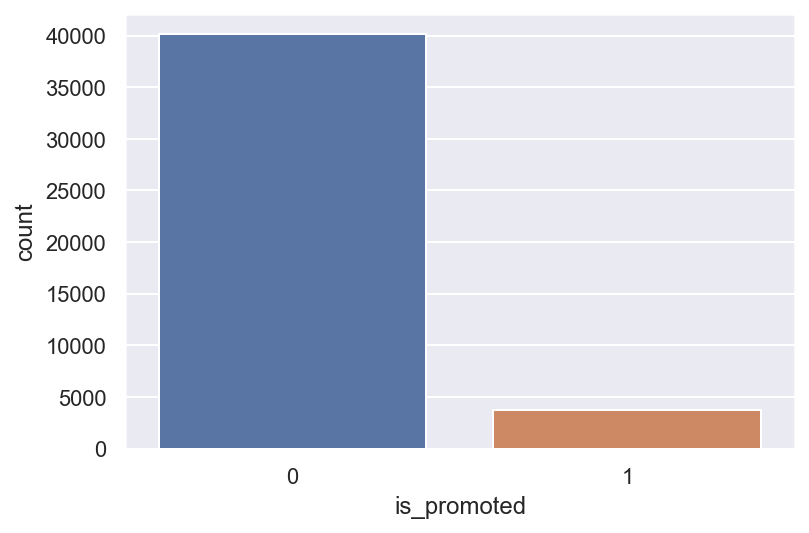

In [86]:
sns.countplot(x = y_train)
pass

In [87]:
rus = RandomUnderSampler(sampling_strategy = 0.8, random_state = seed)
ros = RandomOverSampler(sampling_strategy = 0.8, random_state = seed)

In [88]:
X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train)
X_ros, y_ros = ros.fit_resample(X_train_scaled, y_train)

In [89]:
y_rus.value_counts()

0    4667
1    3734
Name: is_promoted, dtype: int64

In [90]:
y_ros.value_counts()

0    40112
1    32089
Name: is_promoted, dtype: int64

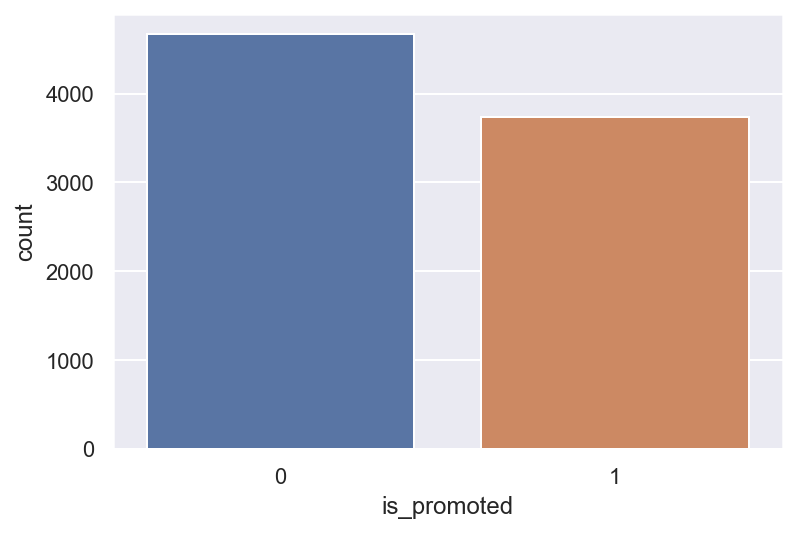

In [91]:
sns.countplot(x = y_rus)
pass

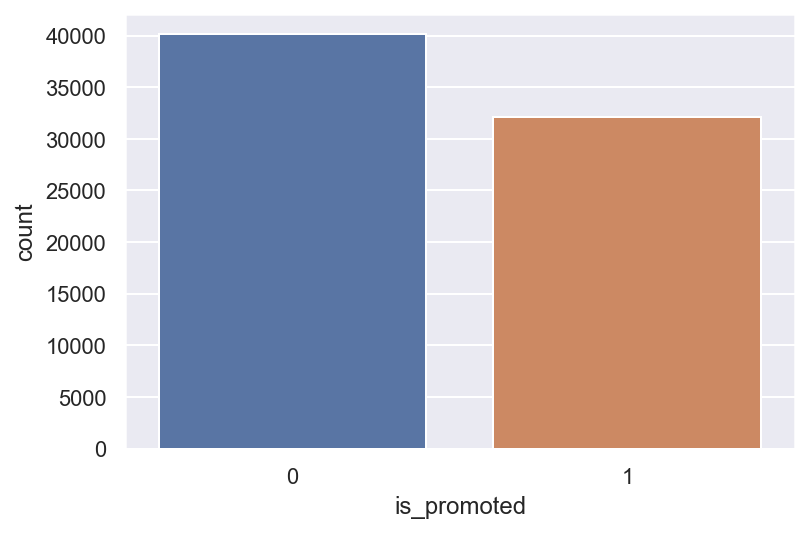

In [92]:
sns.countplot(x = y_ros)
pass

### `Se evaluaran ambos criterios de balanceo de muestras al entrenar los modelos`

## Modelamiento

### Random Forest

In [96]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [5, 10],
          'min_samples_split': [10, 25, 50],
          'n_estimators': [25, 50, 100],
          'random_state': [seed]}

In [98]:
rf = RandomForestClassifier()

In [106]:
gs_rus = GridSearchCV(estimator = rf, param_grid = params, scoring = 'roc_auc')
gs_ros = GridSearchCV(estimator = rf, param_grid = params, scoring = 'roc_auc')

In [112]:
gs_rus.fit(X_rus, y_rus)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'min_samples_split': [10, 25, 50],
                         'n_estimators': [25, 50, 100],
                         'random_state': [314159]},
             scoring='roc_auc')

In [113]:
gs_rus.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50,
                       random_state=314159)

In [114]:
gs_rus.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_split': 10,
 'n_estimators': 50,
 'random_state': 314159}

In [115]:
gs_rus.best_score_

0.867314468299951

In [107]:
gs_ros.fit(X_rus, y_rus)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'min_samples_split': [10, 25, 50],
                         'n_estimators': [25, 50, 100],
                         'random_state': [314159]},
             scoring='roc_auc')

In [108]:
gs_ros.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50,
                       random_state=314159)

In [109]:
gs_ros.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_split': 10,
 'n_estimators': 50,
 'random_state': 314159}

In [111]:
gs_ros.best_score_

0.867314468299951

### usamos el mejor random forest para evaluar el test

In [116]:
best_rf = gs_rus.best_estimator_

In [121]:
y_test_pred_proba = best_rf.predict_proba(X_test_scaled)[:,1]

In [124]:
roc_auc_score(y_test, y_test_pred_proba)

0.8678435925447292

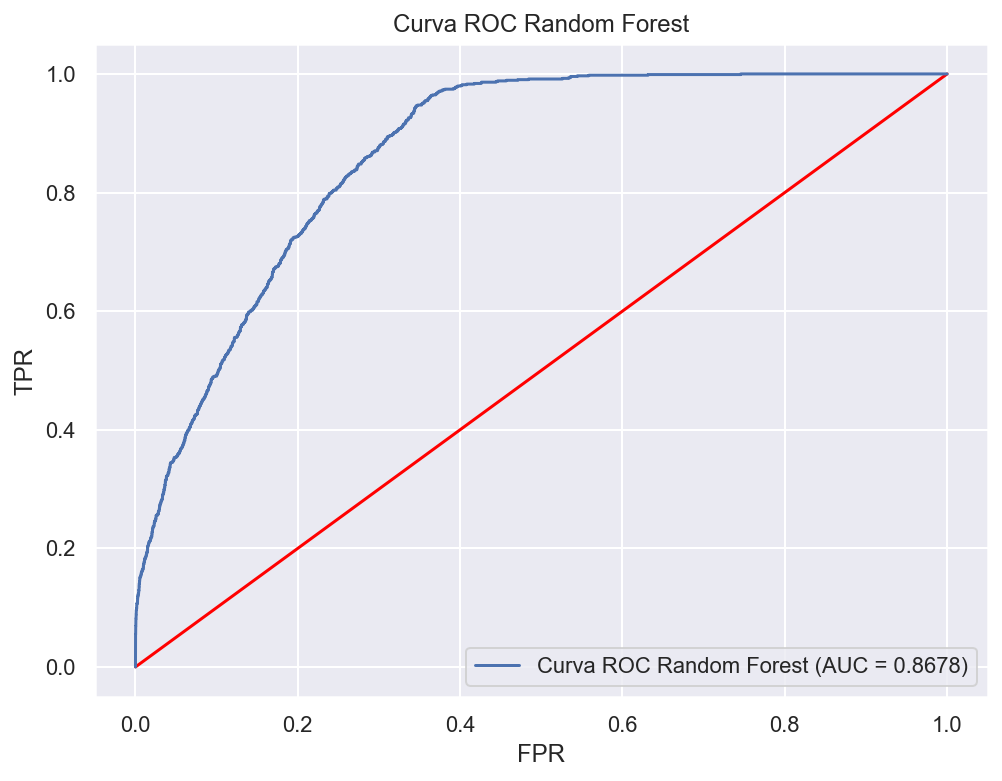

In [125]:
plot_roc_curve(y_test, y_test_pred_proba, 'Random Forest')

### XGBoost

In [226]:
# dtrain_rus = xgb.DMatrix(data=X_rus,    label = y_rus)
# dtrain_ros = xgb.DMatrix(data=X_ros,    label = y_ros)
# dtest = xgb.DMatrix(data=X_test_scaled, label = y_test)

In [225]:
# watch_list_rus  = [(dtrain_rus,'train'),(dtest,'test')]
# watch_list_ros  = [(dtrain_ros,'train'),(dtest,'test')]

In [235]:
parameters = {
        'min_child_weight': [0.5, 1],
        'gamma': [2, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'max_depth': [3, 4]
        }

In [236]:
xgb = xgbc(n_estimators=600, objective='binary:logistic', nthread=1, learning_rate = 0.05)

In [237]:
gs_rus = GridSearchCV(estimator = xgb, param_grid = parameters, scoring = 'roc_auc')
gs_ros = GridSearchCV(estimator = xgb, param_grid = parameters, scoring = 'roc_auc')

In [238]:
gs_rus.fit(X_rus, y_rus)

[01:10:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:10:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=600, n_jobs=None, nthread=1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validat

In [240]:
gs_rus.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [241]:
gs_rus.best_params_

{'colsample_bytree': 1.0,
 'gamma': 5,
 'max_depth': 4,
 'min_child_weight': 0.5,
 'subsample': 0.8}

In [242]:
gs_rus.best_score_

0.9075873337253281

In [243]:
gs_ros.fit(X_ros, y_ros)

[01:33:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
